In [1]:
import re
import os
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy.units as u
import pandas as pd

from src.utils import *
from src.GMM import *

%load_ext autoreload
%autoreload 2

In [2]:
drct = "../scripts/get_globular_clusters/result.txt"
summary_table = pd.read_csv(drct, sep='\t')
summary_table = summary_table.iloc[1:,:]
summary_table.rename(columns={'# Name         ':'Name'}, inplace=True)
summary_table['Name'] = summary_table['Name'].str.strip()
summary_table.set_index('Name', inplace=True)
summary_table.head()

,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp
Name,,,,,,,,,,,,,,,
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.30,0.418
NGC_288,13.1885,-26.582,8.9,-44.8,0.1,3.3,12.0,4.267,-5.636,0.054,0.053,0.018,2555.2,6.05,0.082
NGC_362,15.8094,-70.848,8.6,223.3,0.3,8.8,12.0,6.730,-2.535,0.053,0.052,-0.004,1741.3,7.80,0.149
Whiting_1,30.7375,-3.2527,30.1,-130.4,1.8,0.3,3.0,-0.234,-1.782,0.115,0.094,-0.050,11.1,0.48,0.000
NGC_1261,48.0675,-55.216,16.3,71.4,0.2,5.8,10.0,1.632,-2.038,0.057,0.057,0.009,541.7,4.10,0.093


In [3]:
summary_table.loc['NGC_104_47Tuc', 'rscale']

'18.30'

### Read and initial plot of data

In [4]:
drct = "../scripts/get_globular_clusters/output"

In [5]:
gc = pd.read_csv(os.path.join(drct, "NGC_104_47Tuc.csv"), skiprows=54, sep=" ")
gc.head()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob
0,-0.197768,-0.588896,4.437221,-3.046831,2.568937,2.304999,-0.435020,20.77880,0.816515,0,0.00000
1,-0.132277,-0.576262,-0.060467,-1.399454,1.140334,1.009628,-0.308144,20.19374,0.838819,0,0.00000
2,-0.130210,-0.584196,25.034540,2.431298,1.950605,1.598516,-0.185372,20.80205,2.071041,0,0.00000
3,-0.134829,-0.422390,4.965001,-1.958991,0.432121,0.295054,-0.275978,18.64288,0.965523,1,0.96083
4,-0.127499,-0.603662,0.654260,-0.609768,0.179726,0.137382,-0.125604,17.40447,1.302572,1,0.00000


In [6]:
gc["r"] = np.hypot(gc.x, gc.y)
gc["pm"] = np.hypot(gc.pmx, gc.pmy)

In [7]:
gc.describe()

,x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
count,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,126380.000000,107806.000000,126380.000000,126380.000000,126380.000000,126380.000000
mean,0.020448,-0.011716,4.551414,-2.277182,0.814111,0.675568,-0.111159,18.850155,0.935921,0.291953,0.189248,0.244169,5.624450
std,0.205895,0.208160,3.258890,2.235275,0.747640,0.661056,0.197171,1.388324,0.246328,0.454663,0.384176,0.163278,3.143767
min,-0.666213,-0.665482,-185.768100,-81.400120,0.023578,0.020528,-0.951285,10.600150,-1.243570,0.000000,0.000000,0.001046,0.014232
25%,-0.099703,-0.122219,3.726735,-2.915028,0.309020,0.250860,-0.225217,18.053233,0.801764,0.000000,0.000000,0.119399,4.726025
50%,0.011500,-0.006981,5.071260,-2.351073,0.573033,0.453512,-0.106138,19.053915,0.906712,0.000000,0.000000,0.191362,5.741681
75%,0.128428,0.105823,5.723011,-1.571697,1.048152,0.830895,-0.003526,19.852253,1.041331,1.000000,0.000000,0.331209,6.408186
max,0.666002,0.666213,107.301200,213.179700,5.227345,5.292846,0.982183,20.999300,4.339368,1.000000,0.998725,0.666647,282.763809


Spatial Distribution

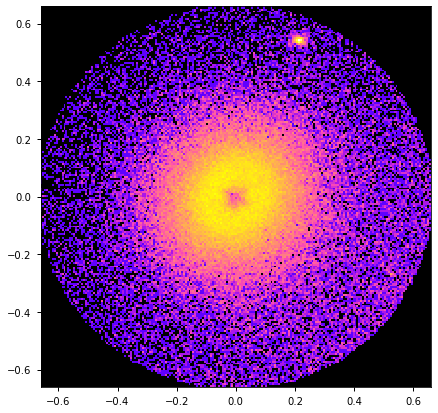

In [8]:
plt.figure(figsize=(7,7))
H, xb, yb, _ = plt.hist2d(gc.x, gc.y, bins=200, range=[[-0.66,0.66],[-0.66,0.66]], norm=LogNorm(), cmap="gnuplot2")

Text(0.5, 0, 'r')

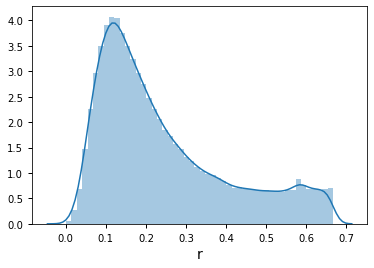

In [9]:
sns.distplot(gc.r)
plt.xlabel("r")

Pruning by scale radius and upper limit of proper motion

In [10]:
gcs = gc[(gc.r<18.3/60) & (gc.pm<15)]

Text(0.5, 0, 'r')

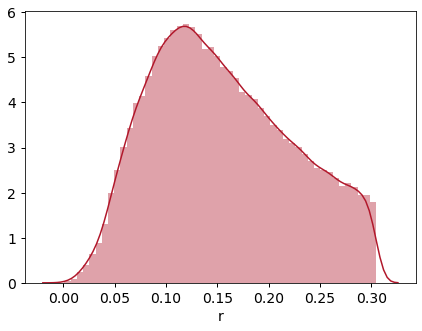

In [23]:
sns.distplot(gcs.r)
plt.xlabel("r")

Distribution of proper motion

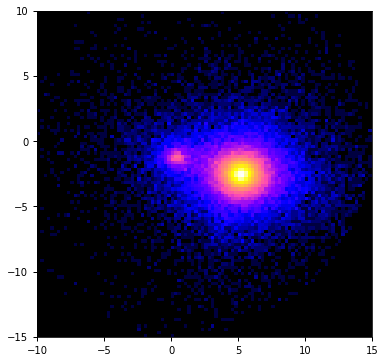

In [11]:
plt.figure(figsize=(6,6))
H, xb, yb, _ = plt.hist2d(gcs.pmx, gcs.pmy, bins=100, range=[[-10,15],[-15,10]], norm=LogNorm(), cmap="gnuplot2")

Text(0.5, 0, 'PM')

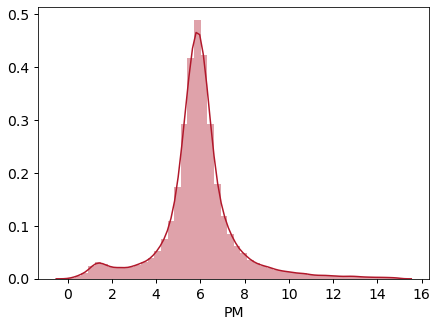

In [22]:
sns.distplot(gcs.pm[gcs.pm<15])
plt.xlabel("PM")

Text(0, 0.5, 'PM')

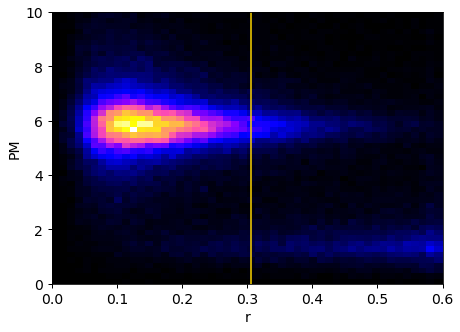

In [26]:
H, xb, yb, _ = plt.hist2d(gc.r, gc.pm, bins=50, range=[[0,0.6],[0,10]], cmap="gnuplot2")
# R scale
plt.axvline(18.3/60, color="gold")
plt.xlabel("r")
plt.ylabel("PM")

### Binning Start From Here

Bin the distribution of pm in radial bins.

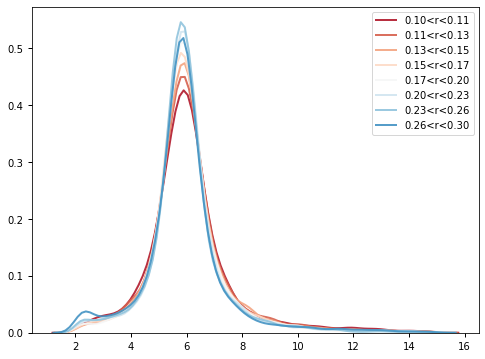

In [14]:
bins = np.logspace(np.log10(0.1), np.log10(0.3), 9)

sns.set_palette("RdBu", len(bins))
r_rbin, z_rbin = profile_binning(gc.r, gc.pm, bins=bins, z_clip=[2,15],
                                 return_bin=False, plot=True)

Acquire all the stars from a particular bin:

In [15]:
z_bins = profile_binning(gcs.r, gcs.pm, bins=bins, z_clip=[2,15],
                         return_bin=True, plot=False)

In [16]:
z_bins["5"]

{'pm': array([6.00306609, 5.63815403, 3.6475262 , ..., 4.71123033, 6.73842532,
        4.08646443]),
 'r': array([0.22197456, 0.20309179, 0.21747407, ..., 0.21703462, 0.22469346,
        0.21869273])}

PM radial profile

Text(0, 0.5, 'PM')

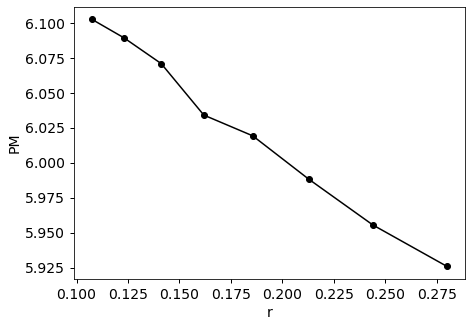

In [27]:
plt.figure(figsize=(7,5))
plt.plot(r_rbin, z_rbin, "k-o")
plt.xlabel("r")
plt.ylabel("PM")

### GMM start from here

Perform GMM decomposition. The best number of gaussians is given by the lowest BIC. One can also specify the number of components by giving values to parameter n_comp in GMM( ).

In [18]:
gmm_bins = []
for i in range(len(bins)-1):
    gcb = gcs[(bins[i]<gcs.r)&(gcs.r<bins[i+1])]
    gmm = GMM(gcb.pm, max_n_comp=6, verbose=False)
    gmm_bins.append(gmm)

TypeError: __init__() got an unexpected keyword argument 'max_n_comp'

Probability that a star is giving by the major population. Passing a subsample

In [ ]:
prob_main_pop = predict_main_pop(z_bins["5"]["pm"], gmm_bins[5])
prob_main_pop

Visualize GMM discrimination in each bin:

In [ ]:
plot_predict_main_pop(gcs, bins, gmm_bins, p_thre=0.8)

Visualize GMM results combining bins:

In [ ]:
for i, b in enumerate(bins[:-1]):
    
    r = z_bins[str(i)]["r"]
    pm = z_bins[str(i)]["pm"]
    gmm = gmm_bins[i]
    
    prob_main_pop = predict_main_pop(pm, gmm)
    is_main_pop = prob_main_pop > 0.8
    
    plt.scatter(r[is_main_pop], pm[is_main_pop], color="navy", alpha=0.1, s=2)
    plt.scatter(r[~is_main_pop], pm[~is_main_pop], color="gold", alpha=0.3, s=5)
    plt.axvline(bins[i], color="k", alpha=0.2)
    plt.ylabel("Proper Motion (mas)")
    plt.xlabel("Radius (deg)")
    plt.ylim(0, 15)
plt.show()

# Surface Density DON'T NEED TO DO

TODO a much better estimate of the surface density than just a histrogram

In [ ]:
suface_density = []

for i, b in enumerate(bins[:-1]):
    
    r = z_bins[str(i)]["r"]
    pm = z_bins[str(i)]["pm"]
    gmm = gmm_bins[i]
    
    prob_main_pop = predict_main_pop(pm, gmm)
    is_main_pop = prob_main_pop > 0.8
    
    area = np.pi * (bins[i+1]**2 - b**2)
    suface_density.append(len(r) / area)

plt.plot((bins[:-1]+bins[1:])/2, suface_density)

In [ ]:
import astropy
from astropy.modeling.functional_models import KingProjectedAnalytic1D
from astropy.modeling import models, fitting

In [ ]:
x = (bins[:-1]+bins[1:])/2
y = suface_density
KP_int = KingProjectedAnalytic1D(amplitude = 1, r_core = 1., r_tide = 1)

fit_KP = fitting.LevMarLSQFitter()
KP = fit_KP(KP_int, x, y, maxiter=1000)

plt.figure(figsize=(8,5))
plt.loglog(x, y, 'ko')
plt.plot(x, KP(x), label='Gaussian')

In [ ]:
KP.amplitude, KP.r_core, KP.r_tide

# Velocity Dispersion

Assume Plummer sphere model.

Still need to normalize.

Do better fit:

    - https://symfit.readthedocs.io/en/stable/intro.html
    - https://lmfit.github.io/lmfit-py/fitting.html
    - and an MCMC (can use symfit)

In [ ]:
from galpy.df import jeans
from galpy import potential

x = (bins[:-1]+bins[1:])/2 / summary_table

In [ ]:
%%time

for amp, scale in zip(np.linspace(10, 100, num=20), np.linspace(0.1, 5, num=20)):
    pot = potential.PlummerPotential(amp=amp, b=scale) 
    model = np.array([jeans.sigmar(pot, r) for r in x])

In [ ]:
# Grid Parameters for 47 Tuc

gc_amp = np.logspace(9e5, 1.1e6, num=5e1) * u.solMass  # The GC mass varies pretty wildly: 10^4 - few*10^6
gc_scale = np.linspace(0.5, 1.5, num=1e2)
bh_amp = np.linspace(0, 1e5, num=1e2) * u.solMass

# radius
radii = np.linspace(0, 10, num=1e3)  # units of radius / scale_radius


In [ ]:
pot = potential.PlummerPotential(amp=gc_amp, b=gc_scale * )

In [ ]:
potential.PlummerPotential??

In [ ]:
rnorm = ((x * u.deg).to_value(u.rad) / (18.3 *u.arcmin).to_value(u.rad))

from astropy import units as u
amp = 10**6 * u.solMass
scale = 1

pot = potential.PlummerPotential(amp=amp, b=scale)
model1 = np.array([jeans.sigmar(pot, r).to_value(u.km/u.s) for r in rnorm]) * u.km / u.s
plt.plot(x, model1, label='NO')

bh_amp=10**3 * u.solMass
amp = 10**6 * u.solMass - bh_amp
pot = potential.PlummerPotential(amp=amp, b=scale) + potential.KeplerPotential(amp=bh_amp)
model2 = np.array([jeans.sigmar(pot, r).to_value(u.km/u.s) for r in rnorm]) * u.km / u.s
plt.plot(x, model2, label='1e3')

bh_amp=10**4 * u.solMass
amp = 10**6 * u.solMass - bh_amp
pot = potential.PlummerPotential(amp=amp, b=scale) + potential.KeplerPotential(amp=bh_amp)
model3 = np.array([jeans.sigmar(pot, r).to_value(u.km/u.s) for r in rnorm]) * u.km / u.s
plt.plot(x, model3, label=1e4)
plt.legend()

In [ ]:
import astropy.units as u
from lmfit import Parameters, fit_report, minimize
import galpy
from galpy.df import jeans
from galpy import potential

fit_params = Parameters()
fit_params.add('amp', value=100000, min=0)
fit_params.add('scale', value=1, min=0)


def residual(pars, x, data=None):
    """Model and subtract data."""
    vals = pars.valuesdict()
    amp = vals['amp']
    scale = vals['scale']

    pot = potential.PlummerPotential(amp=amp, b=scale) 
    model = np.array([jeans.sigmar(pot, r) for r in x])

    if data is None:
        return model
    return model - data


# getting data
vel_disp = []
for i, b in enumerate(bins[:-1]):
    
    r = z_bins[str(i)]["r"]
    pm = z_bins[str(i)]["pm"]
    gmm = gmm_bins[i]
    
    prob_main_pop = predict_main_pop(pm, gmm)
    is_main_pop = prob_main_pop > 0.8

    vs = ((4 * u.kpc) * pm[is_main_pop] * u.mas/u.yr).to_value(u.km*u.rad/u.s)
    
    disp = np.var(vs)
    
    vel_disp.append(disp)

x = (bins[:-1]+bins[1:])/2
data = vel_disp

plt.plot(x, vel_disp)
mi = minimize(residual, fit_params, args=(x,), kws={'data': data})

print(fit_report(mi))

In [ ]:
plt.plot(x, data, 'b')
plt.plot(x, data + residual(mi.params, x, data=data), 'r', label='best fit')
plt.legend(loc='best')
plt.show()

With a BH

In [ ]:
import astropy.units as u
from lmfit import Parameters, fit_report, minimize
import galpy
from galpy.df import jeans
from galpy import potential

fit_params = Parameters()
fit_params.add('amp', value=100000, min=0)
fit_params.add('scale', value=1, min=0)
fit_params.add('bh_amp', value=10000, min=0)


def residual(pars, x, data=None):
    """Model and subtract data."""
    vals = pars.valuesdict()
    amp = vals['amp']
    scale = vals['scale']
    bh_amp = vals['bh_amp']

    pot = potential.PlummerPotential(amp=amp, b=scale) + potential.KeplerPotential(amp=bh_amp)
    model = np.array([jeans.sigmar(pot, r) for r in x])

    if data is None:
        return model
    return model - data


# getting data
vel_disp = []
for i, b in enumerate(bins[:-1]):
    
    r = z_bins[str(i)]["r"]
    pm = z_bins[str(i)]["pm"]
    gmm = gmm_bins[i]
    
    prob_main_pop = predict_main_pop(pm, gmm)
    is_main_pop = prob_main_pop > 0.8

    vs = ((4 * u.kpc) * pm[is_main_pop] * u.mas/u.yr).to_value(u.km*u.rad/u.s)
    
    disp = np.var(vs)
    
    vel_disp.append(disp)

x = (bins[:-1]+bins[1:])/2
data = vel_disp

mi = minimize(residual, fit_params, args=(x,), kws={'data': data})

plt.plot(x, data, 'b')
plt.plot(x, data + residual(mi.params, x, data=data), 'r', label='best fit')
plt.legend(loc='best')
plt.show()

print(fit_report(mi))

In [ ]:
galpy.potential.Kin 

In [ ]:
# raise Exception('Run MCMC?')

# import lmfit as lf

# mi.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

# res = lf.minimize(residual, method='emcee', args=(x,), kws={'data': data}, nan_policy='omit', burn=300, steps=1000, thin=20,
#                   params=mi.params, is_weighted=False, progress=True)

# plt.plot(res.acceptance_fraction)
# plt.xlabel('walker')
# plt.ylabel('acceptance fraction')
# plt.show()

# import corner

# emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
#                            truths=list(res.params.valuesdict().values()))